In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from sklearn.preprocessing import LabelEncoder

from torchmetrics import Recall, Precision, Accuracy

import matplotlib.pyplot as plt
import numpy as np
import cv2 
import os

In [64]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [129]:
class ImageDataset(Dataset): 
    def __init__(self, image_paths, labels, label_encoder, transform = None): 
        self.image_paths = image_paths
        self.labels = labels        
        self.label_encoder = label_encoder
        self.transform = transform

        # Create class_to_idx map manually
        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}

    def __len__(self): 
        return len(self.image_paths) 

    def __getitem__(self, idx): 
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (28, 28))  # Resize to the desired size
        image = image[:, :, None]  # Add channel dimension
        
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
    def decode_label(self, encoded_label):
        return self.label_encoder.inverse_transform([encoded_label])[0]
    
    def decode_labels(self, encoded_labels):
        return self.label_encoder.inverse_transform(encoded_labels)

In [40]:
def extract_label(filename):
    return filename.split('.')[0]

def load_dataset(root_dir):
    image_paths = []
    labels = []

    for root, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".jpg"):
                file_path = os.path.join(root, filename)
                label = extract_label(filename)
                image_paths.append(file_path)
                labels.append(label)

    # Label encoding the labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    return image_paths, labels, label_encoder    

In [4]:
# Define transformations 
transform = transforms.Compose([
    transforms.ToTensor(), # Parse to Tensor
    transforms.Normalize((0.5,),(0.5)), # Normalize 
    transforms.Resize((28, 28)) # Resize by 28x28
])

In [127]:
# Load the dataset
image_paths, labels, label_encoder = load_dataset('/kaggle/input/baybayn-baybayin-handwritten-images')

In [131]:
# Create the dataset 
dataset = ImageDataset(image_paths, labels, label_encoder, transform=transform)

# Split the Dataset 
train_size = int(0.8*len(dataset)) # 80% training data  - 20% test data
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) 

print(f"Dataset Size {len(dataset)}\nTraining Dataset Size: {len(train_dataset)}\nTest Dataset Size: {len(test_dataset)}")

Dataset Size 9833
Training Dataset Size: 7866
Test Dataset Size: 1967


In [55]:
num_classes = len(np.unique(labels))
labels_decoded = label_encoder.inverse_transform(np.unique(labels))
print(f"Number of classes: {num_classes}")
print(labels_decoded)

Number of classes: 63
['a' 'b' 'ba' 'be_bi' 'bo_bu' 'd' 'da_ra' 'de_di' 'do_du' 'e_i' 'g' 'ga'
 'ge_gi' 'go_gu' 'h' 'ha' 'he_hi' 'ho_hu' 'k' 'ka' 'ke_ki' 'ko_ku' 'l'
 'la' 'le_li' 'lo_lu' 'm' 'ma' 'me_mi' 'mo_mu' 'n' 'na' 'ne_ni' 'ng' 'nga'
 'nge_ngi' 'ngo_ngu' 'no_nu' 'o_u' 'p' 'pa' 'pe_pi' 'po_pu' 'r' 'ra'
 're_ri' 'ro_ru' 's' 'sa' 'se_si' 'so_su' 't' 'ta' 'te_ti' 'to_tu' 'w'
 'wa' 'we_wi' 'wo_wu' 'y' 'ya' 'ye_yi' 'yo_yu']


In [132]:
# Create dataloader 
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

<hr />

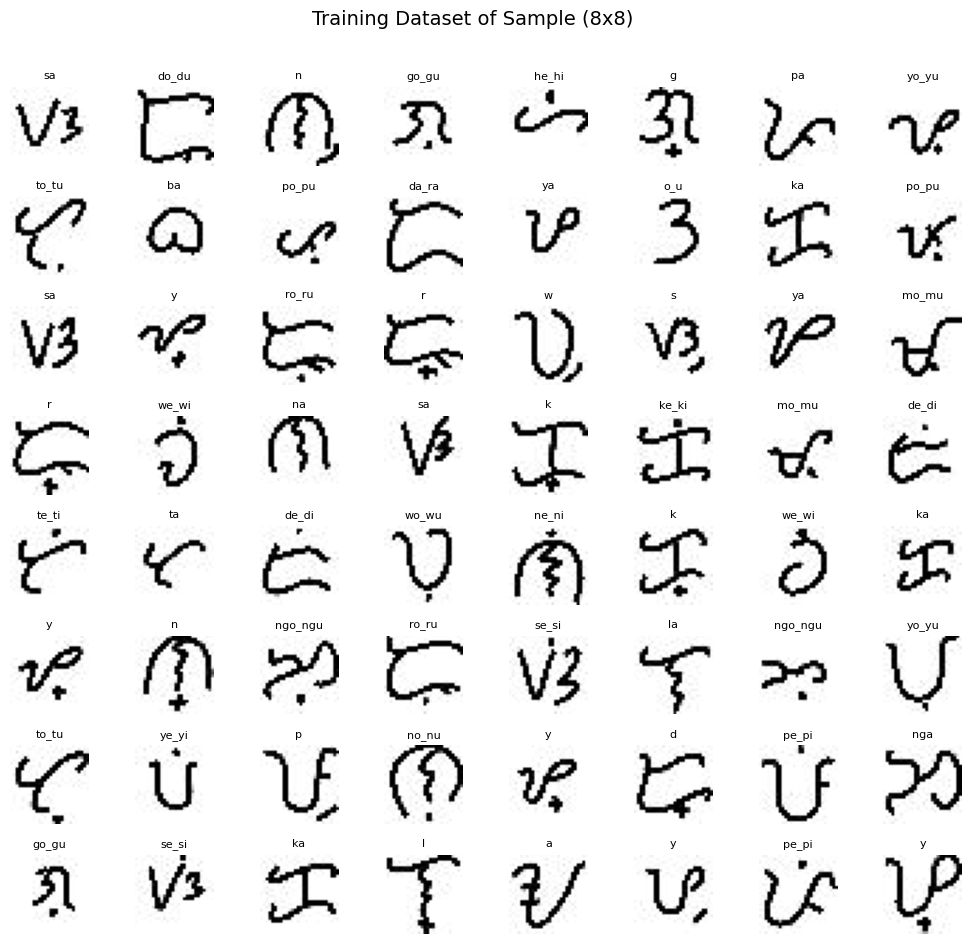

In [62]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(8,8, figsize=(10,10))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(len(train_dataset))

    # Select rows corresponding to the random indices and
    image ,label = train_dataset[random_index]
    
    X_random_reshaped = image.reshape((28,28))
    label = label_encoder.inverse_transform([label])[0]

    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Display the label above the image
    ax.set_title(label, fontsize=8)
    ax.set_axis_off()
    fig.suptitle("Training Dataset of Sample (8x8)", fontsize=14)

# Convolutional Neural Network Model

```python
    torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
```

<h4>Key Parameters</h4>

1. in_channels **(num input channels)**
    - The number of input channels (**1 for grayscale** images).
2. Out Channels **(# of Kernels)**
    - The number of filters is a hyperparameter that is typically determined through experimentation; In an early convolutional layer, you might start with a smaller number of filters (e.g., 32 or 64) and increase this number as you move deeper into the network (e.g., 128, 256 filters).
3. kernel_size 
    - The size of the convolutional filter (e.g., a 3x3 filter, or a 5x5 filter).
    - A **3x3 kernel** is often preferred as it is smaller, requires fewer parameters, and has been found effective in practice.
    - A **5x5 kernel** can be used when you want to capture larger spatial features, but it comes with more parameters and requires more computation.
4. padding 
    - Helps preserve the spatial dimensions of the input after convolution, or it can reduce them in a controlled way

You can determine Output size by: 
$$ \text{Output Size} = \left\lfloor \frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} \right\rfloor + 1 $$

$$ \text{Output Size} = \left\lfloor \frac{\text{Input size}}{\text{Pool size}} \right\rfloor $$


In [79]:
class Net(nn.Module): 
    def __init__(self, num_classes): 
        super().__init__() 

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1*28*28 -> 32*28*28
            nn.ELU(), 
            nn.MaxPool2d(2),  # 32*14*14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32*14*14 -> 64*14*14
            nn.ELU(), 
            nn.MaxPool2d(2),  # 64*7*7

            nn.Flatten(),            
        )

        self.classifier = nn.Linear(64*7*7, num_classes)

    def forward(self, x): 
        x = self.feature_extractor(x) 
        x = self.classifier(x)
        return x

### Explanation

$$ \text{Output Size} = \left\lfloor  \right\rfloor $$

# Training

In [80]:
# Create our Model
model = Net(num_classes = num_classes).to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [82]:
num_epochs = 10

for epoch in range(num_epochs): 
    for idx, (images, labels) in enumerate(train_dataloader): 
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print("Finished Training")

Finished Training


# Evaluate the Model

In [88]:
# Setup Metrics
metric_precision = Precision(task="multiclass", num_classes=num_classes, average='macro').to(device)
metric_recall = Recall(task="multiclass", num_classes=num_classes, average='macro').to(device)
metric_accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)

# Evaluate the model
model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        metric_precision(preds, labels)
        metric_recall(preds, labels)
        metric_accuracy(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
accuracy = metric_accuracy.compute()

print(f"Precision = {precision}\n Recall = {recall}\nAccuracy = {accuracy}")

Precision = 0.9293432235717773
 Recall = 0.9284327030181885
Accuracy = 0.9262836575508118


### Metrics Per Class

In [133]:
# Analyzing performance per class
metric_precision_p = Precision(task="multiclass", num_classes=num_classes, average = None).to(device)
metric_recall_p = Recall(task="multiclass", num_classes=num_classes, average= None).to(device)
metric_accuracy_p = Accuracy(task="multiclass", num_classes=num_classes).to(device)

model.eval()

with torch.no_grad():
    for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        metric_precision_p(predicted, labels)
        metric_recall_p(predicted, labels)
        metric_accuracy_p(predicted, labels)

precision_per_cass = metric_precision_p.compute()
recall_per_cass = metric_recall_p.compute()
accuracy_per_cass = metric_accuracy_p.compute()

# Reverse the class_to_idx to create idx_to_class map
idx_to_class = {
    idx: label_encoder.inverse_transform([int(class_name)])[0]
    for class_name, idx in test_dataset.dataset.class_to_idx.items()
}

# Print per-class metrics with class names
for class_index in range(num_classes):    
    if class_index in idx_to_class:
        class_name = idx_to_class[class_index]  # Get the class name from the index
        print(f'{class_name}: Precision = {precision_per_cass[class_index].item():.2f}, Recall = {recall_per_cass[class_index].item():.2f}')
    else:
        print(f"Class index {class_index} not found in idx_to_class.")

# Print overall accuracy
print(f"Overall Accuracy = {accuracy.item()}")

a: Precision = 0.97, Recall = 0.97
b: Precision = 0.97, Recall = 1.00
ba: Precision = 0.89, Recall = 1.00
be_bi: Precision = 1.00, Recall = 0.97
bo_bu: Precision = 1.00, Recall = 0.97
d: Precision = 1.00, Recall = 1.00
da_ra: Precision = 1.00, Recall = 1.00
de_di: Precision = 1.00, Recall = 1.00
do_du: Precision = 1.00, Recall = 0.96
e_i: Precision = 1.00, Recall = 1.00
g: Precision = 1.00, Recall = 1.00
ga: Precision = 0.95, Recall = 1.00
ge_gi: Precision = 1.00, Recall = 0.96
go_gu: Precision = 1.00, Recall = 1.00
h: Precision = 1.00, Recall = 0.97
ha: Precision = 1.00, Recall = 1.00
he_hi: Precision = 1.00, Recall = 1.00
ho_hu: Precision = 1.00, Recall = 0.96
k: Precision = 1.00, Recall = 1.00
ka: Precision = 1.00, Recall = 0.94
ke_ki: Precision = 1.00, Recall = 1.00
ko_ku: Precision = 0.96, Recall = 1.00
l: Precision = 1.00, Recall = 0.88
la: Precision = 0.94, Recall = 1.00
le_li: Precision = 1.00, Recall = 1.00
lo_lu: Precision = 0.90, Recall = 1.00
m: Precision = 0.97, Recall = 0

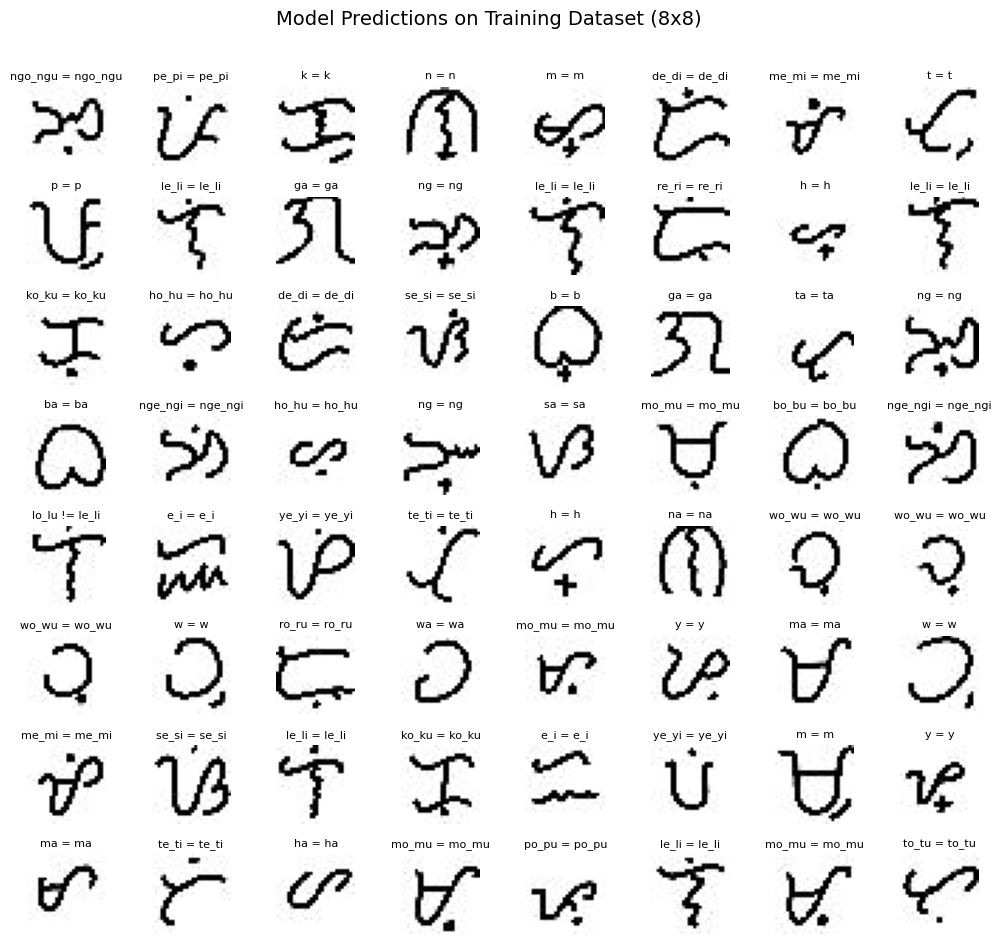

In [138]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(8,8, figsize=(10,10))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

model.eval()
with torch.no_grad():
    for i,ax in enumerate(axes.flat):
        # Select random indices
        random_index = np.random.randint(len(test_dataset))
    
        # Select rows corresponding to the random indices and get image and label
        image, label = train_dataset[random_index]
        label = label_encoder.inverse_transform([label])[0]
    
        # Add a batch dimension since the model expects a batch input
        image = image.unsqueeze(0).to(device)  # image shape is [1, 28, 28]
    
        # Make prediction
        output = model(image)
        _, predicted = torch.max(output, 1)
    
        # Convert the prediction to a class label
        predicted_label = label_encoder.inverse_transform([predicted.item()])[0]
        
        X_random_reshaped = image.squeeze().cpu().numpy()
        # Display the image
        ax.imshow(X_random_reshaped, cmap='gray')
    
        # Display the predicted label above the image
        title = f"{predicted_label} {'!=' if predicted_label != label else '='} {label}"
        ax.set_title(title, fontsize=8)
        ax.set_axis_off()
    
    fig.suptitle("Model Predictions on Training Dataset (8x8)", fontsize=14)    